In [61]:
import os
import matplotlib.pyplot as plt
import pandas as pd


from utils import load_egraph_data


data_dir = "../../data/"

egraph_data = {}

for direc in os.listdir(data_dir):
    egraph_data[direc] = (
        load_egraph_data(f"{data_dir}{direc}/egraph_stats.json"),
        load_egraph_data(f"{data_dir}{direc}/egraph_stats_mem.json"),
    )

egraph_data

{'alive_bitwise': ({'AndOrXor_2243': {'summary': {'iterations': 8,
     'stop_reason': {'Other': 'Found equivalence'},
     'egraph_nodes': 84,
     'egraph_classes': 37,
     'memo_size': 118,
     'rebuilds': 14,
     'total_time': 0.0010824060000000002,
     'search_time': 0.00040668499999999995,
     'apply_time': 0.0006471980000000001,
     'rebuild_time': 2.8153e-05},
    'memory_footprint': None,
    'crude_time': 0.003625983,
    'iteration_info': [{'egraph_nodes': 20,
      'egraph_classes': 19,
      'applied': {'or.commute': 3,
       'and.commute': 2,
       'and_remove': 2,
       'or_remove': 3,
       'not_bw_not-rev': 8,
       'gt-lt': 1},
      'hook_time': 1.3926e-05,
      'search_time': 1.8064e-05,
      'apply_time': 2.3985e-05,
      'rebuild_time': 6.402e-06,
      'total_time': 4.8501e-05,
      'data': None,
      'n_rebuilds': 7,
      'stop_reason': None},
     {'egraph_nodes': 70,
      'egraph_classes': 38,
      'applied': {'demorg_and': 4, 'demorg_or': 6

In [62]:
def prepare_step_data(series):
    times = sorted(series)
    x = [0]
    y = [0]
    for i, t in enumerate(times, start=1):
        x.extend([t, t])
        y.extend([y[-1], i])
    return x, y


out_color_map = {
    "Saturated": "red",
    "Timeout": "blue",
    "NodeLimit": "purple",
}


def create_cactus_plot(df, dir_out = None):
    # Separate solved and unsolved entries
    solved = df[df["outcome"] == "Equivalent"].copy()
    unsolved = df[df["outcome"] != "Equivalent"].copy()

    assert len(solved) + len(unsolved) == len(df)

    solved.sort_values("runtime", inplace=True)
    fig, ax = plt.subplots(figsize=(8, 8))

    x, y = prepare_step_data(solved["runtime"])
    ax.plot(x, y, "-", drawstyle="steps-post")

    ax.set_xlabel("Cumulative Runtime (Seconds)")
    ax.set_ylabel("Number of Problems Solved")
    ax.set_title("Cactus Plot of Problem Solving Performance")
    ax.grid(True, linestyle="--", alpha=0.7)
    # plt.legend()
    ax.set_xscale("log")
    ax.set_ylim(0, len(df))
    if len(unsolved) > 0:
        ax.axhline(len(solved), color="red", linestyle="dashed")
        current_yticks = list(ax.get_yticks())
        if len(solved) not in current_yticks:
            current_yticks.append(len(solved))
            ax.set_yticks(sorted(current_yticks))
    ax.set_ylim(0, len(df))

    # Create a second y-axis with problem names
    ax2 = ax.twinx()
    new_ticks = [*range(0, len(df) + 1)]
    ax2.set_yticks(new_ticks)

    ax2.set_yticklabels(
        [
            f"{i} {name}"
            for i, name in enumerate([""] + [*solved.index] + [*unsolved.index])
        ]
    )
    ax2.set_ylim(ax.get_ylim())
    if len(unsolved) > 0:
        for i, out in enumerate(unsolved.outcome):
            ax2.get_yticklabels()[i + len(solved) + 1].set_color(out_color_map[out])


    # Adjust layout
    plt.tight_layout()
    if dir_out != None:
        plt.savefig(dir_out)
    plt.show()

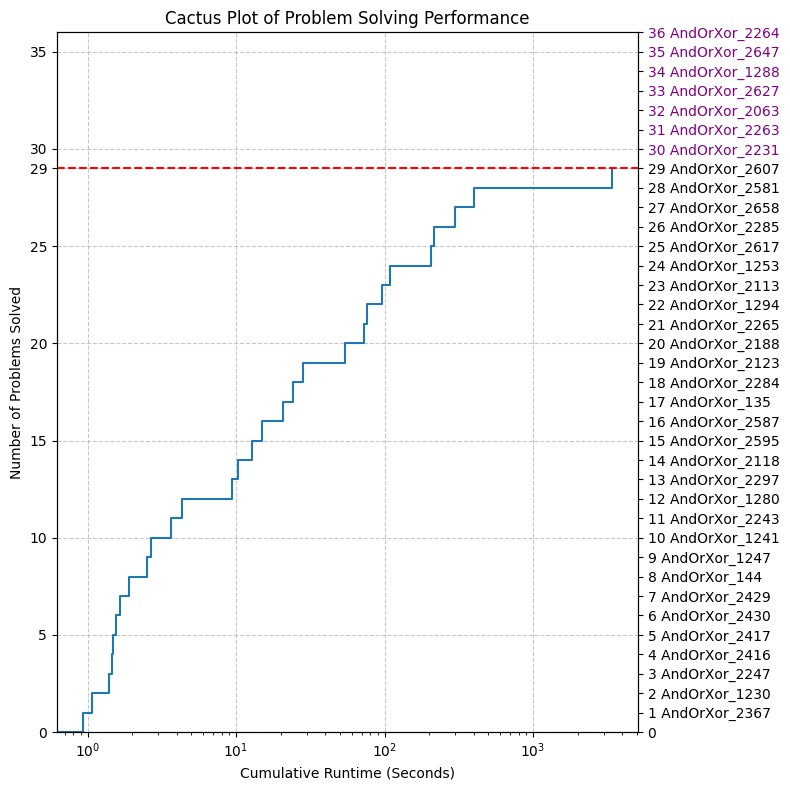

              stop_reason    runtime    memory egraph_nodes egraph_classes  \
AndOrXor_2367  Equivalent      0.937      0.97           66             40   
AndOrXor_1230  Equivalent      1.080      1.24           82             34   
AndOrXor_2416  Equivalent      1.472      1.29           82             34   
AndOrXor_2417  Equivalent      1.479      1.30           81             33   
AndOrXor_2247  Equivalent      1.394      1.24           78             32   
AndOrXor_2430  Equivalent      1.560      1.20           82             34   
AndOrXor_2429  Equivalent      1.648      1.28           78             32   
AndOrXor_144   Equivalent      1.891      1.86           81             37   
AndOrXor_1247  Equivalent      2.509      1.96          158             60   
AndOrXor_1241  Equivalent      2.690      2.13          158             60   
AndOrXor_2243  Equivalent      3.626      3.46           84             37   
AndOrXor_1280  Equivalent      4.323      3.07          165     

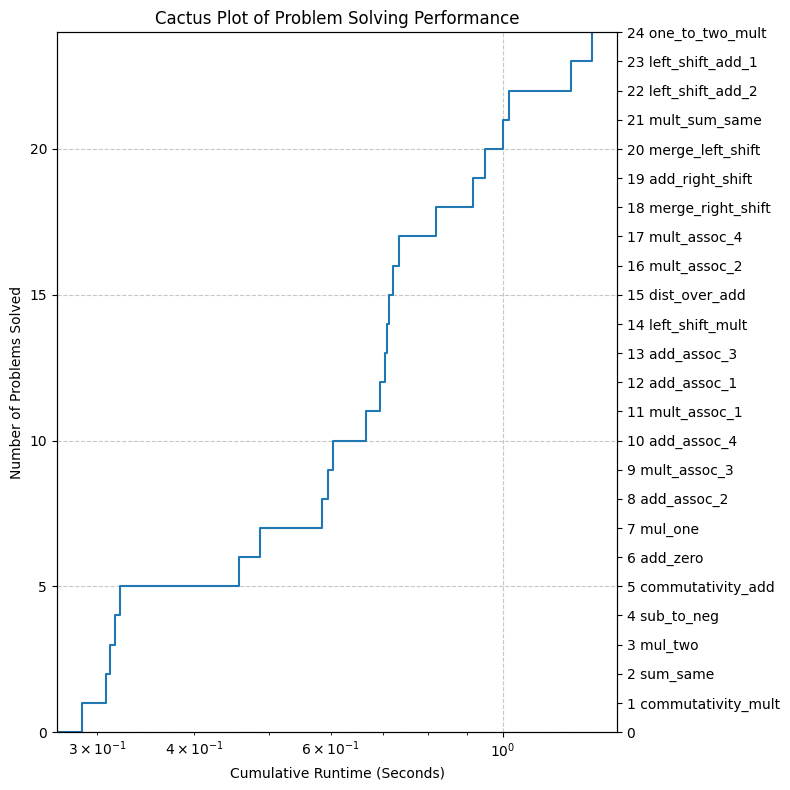

                   stop_reason runtime memory egraph_nodes egraph_classes  \
commutativity_add   Equivalent   0.321   0.44           30             20   
commutativity_mult  Equivalent   0.287   0.44           30             20   
mul_two             Equivalent   0.312   0.45           32             19   
sub_to_neg          Equivalent   0.316   0.48           36             23   
sum_same            Equivalent   0.308   0.45           34             21   
add_zero            Equivalent   0.457   0.59           28             13   
mul_one             Equivalent   0.486   0.60           29             14   
add_assoc_2         Equivalent   0.585   0.76           76             41   
mult_assoc_3        Equivalent   0.596   0.77           74             41   
add_assoc_4         Equivalent   0.604   0.78           73             38   
add_assoc_1         Equivalent   0.695   0.88           81             43   
dist_over_add       Equivalent   0.712   0.92           87             46   

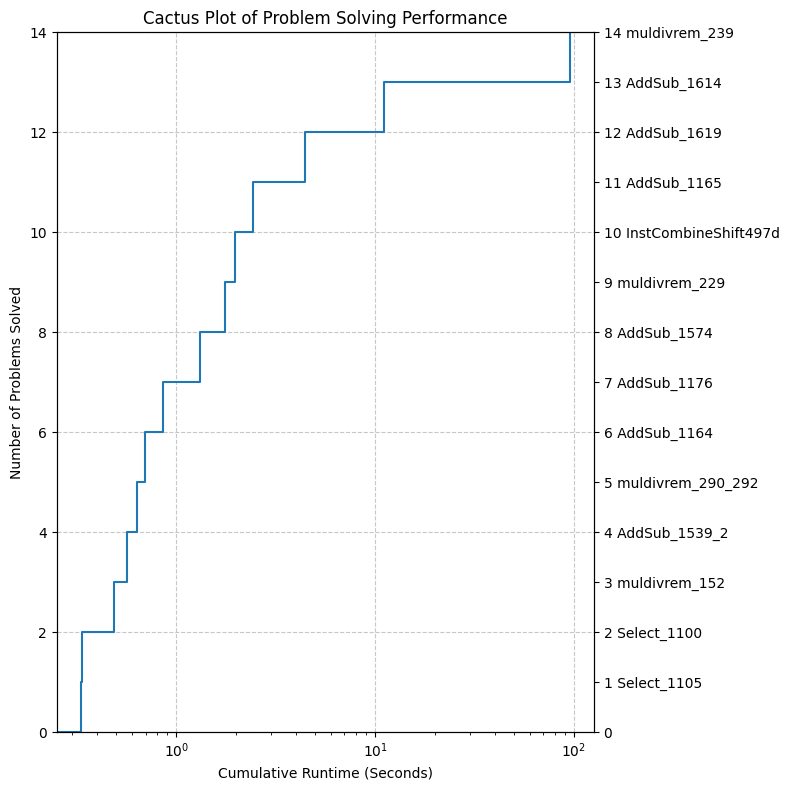

                     stop_reason runtime  memory egraph_nodes egraph_classes  \
Select_1100           Equivalent   0.335    0.35            6              5   
Select_1105           Equivalent   0.333    0.35            6              5   
muldivrem_152         Equivalent   0.486    0.68           55             31   
AddSub_1539_2         Equivalent   0.564    0.76           81             45   
muldivrem_290_292     Equivalent   0.637    0.84           65             40   
AddSub_1176           Equivalent   0.853    1.08           99             53   
AddSub_1164           Equivalent   0.692    0.96           99             53   
AddSub_1574           Equivalent   1.322    1.79          297            131   
muldivrem_229         Equivalent   1.751    2.55          221            106   
AddSub_1165           Equivalent   2.445    3.57          284            120   
InstCombineShift497d  Equivalent   1.979    2.57          266            115   
AddSub_1619           Equivalent   4.460

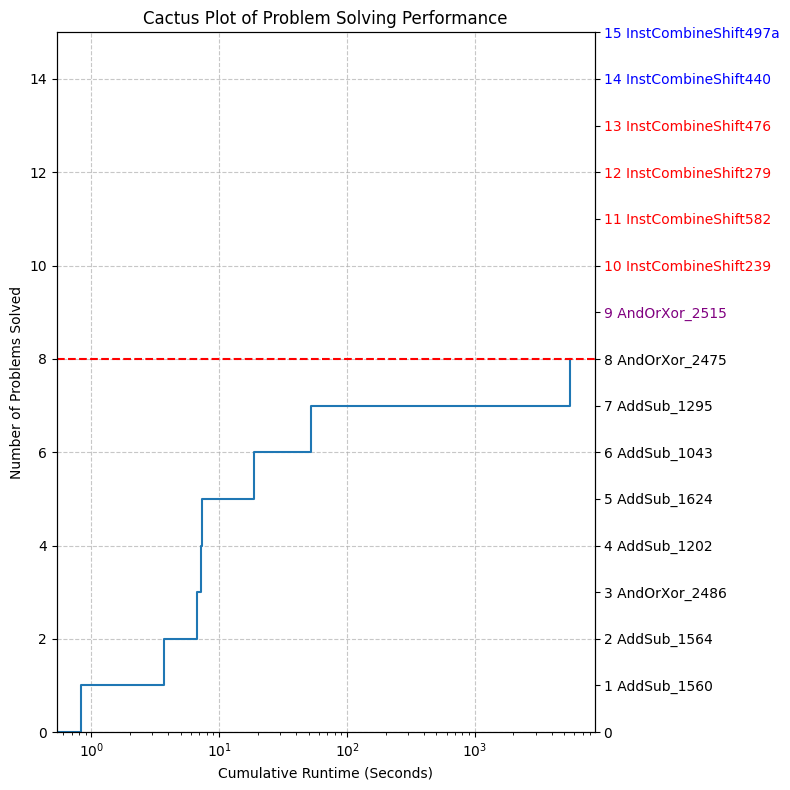

                     stop_reason     runtime    memory egraph_nodes  \
AddSub_1560           Equivalent       0.833      0.74           55   
AddSub_1564           Equivalent       3.708      3.66          445   
AddSub_1202           Equivalent       7.204      5.31          481   
AndOrXor_2486         Equivalent       6.692      4.98          475   
AddSub_1624           Equivalent       7.323      7.98         1013   
AddSub_1043           Equivalent      18.835     31.62         1528   
AddSub_1295           Equivalent      52.287     39.10         2721   
AndOrXor_2475         Equivalent    5560.686   2159.25         7325   
AndOrXor_2515          NodeLimit     968.180    449.64       113958   
InstCombineShift239    Saturated       0.598      0.69           71   
InstCombineShift582    Saturated       0.655      0.69           71   
InstCombineShift279    Saturated       0.939      0.78           79   
InstCombineShift476    Saturated       1.513      1.51          137   
InstCo

In [63]:
def parse_stop(stop):
    match stop:
        case "Saturated":
            return "Saturated"
        case {"Other": "Found equivalence"}:
            return "Equivalent"
        case {"TimeLimit": _limit}:
            return "Timeout"
        case {"NodeLimit": _limit}:
            return "NodeLimit"
        case err:
            raise NotImplementedError(f"This shouldn't happen {err}")


def format_bytes(size_bytes: int) -> str:
    """Convert bytes to a human-readable format (e.g., KB, MB, GB)."""
    # if size_bytes == 0:
    #     return "0B"
    # units = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # power = 2 ** 10  # 1024 (binary system)
    # for unit in units:
    #     if size_bytes < power:
    #         return f"{size_bytes:.0f} {unit}"
    #     size_bytes /= power
    # return f"{size_bytes:.2f} YB"  # Fallback (unlikely)
    # convert to MB
    return f"{size_bytes / 2**20:.2f}"


out_dir = "../../out/results/"
os.makedirs(out_dir, exist_ok=True)

dataframes = {}

for test_set, (data, data_mem) in egraph_data.items():
    processed = {theorem: entry["summary"] for theorem, entry in data.items()}
    for theorem, info in data_mem.items():
        processed[theorem]["memory"] = format_bytes(int(info["memory_footprint"]))
    for theorem, info in data.items():
        # use the crude time since it feels more correct, also convert to milliseconds
        processed[theorem]["runtime"] = info["crude_time"] * 1000
    df = pd.DataFrame(processed)
    df = df.transpose()
    df["stop_reason"] = df["stop_reason"].map(parse_stop)

    df = df.sort_values(by=["stop_reason", "total_time"])

    dataframes[test_set] = df

    order = [
            "stop_reason",
            "runtime",
            "memory",
            "egraph_nodes",
            "egraph_classes",
            "iterations",
        ]

    out_df = df[order
    ].copy()

    create_cactus_plot(out_df.rename(columns={"stop_reason": "outcome"}), f"{out_dir}{test_set}_cactus.pdf")
    out_df["runtime"] = df["runtime"].map(lambda x: f"{x:.3f}")

    renaming = {
            "test": "Test",
            "stop_reason": "Proof Result",
            "runtime": "Run-time (ms)",
            "memory": "Memory (MB)",
            "egraph_nodes": "Nodes",
            "egraph_classes": "E-classes",
            "iterations": "Iterations",
        }
    renaming = {k: r'\textbf{'+v+r'}' for k, v in renaming.items()}


    out_df['test'] = out_df.index.map(lambda x: r'\texttt{' + x + '}')

    with open(f"{out_dir}{test_set}_main.tex", "w") as f:
        f.write(out_df[['test', 'stop_reason', 'runtime', 'memory']].rename(columns=renaming).to_latex(index=False,  column_format='llrr').replace("_", r"\_"))

    with open(f"{out_dir}{test_set}_all.tex", "w") as f:
        f.write(out_df[['test'] + order].rename(columns=renaming).to_latex(index=False).replace("_", r"\_"))


    print(out_df)

In [64]:
benchmark_names = {
    "alive_arith": "Alive Arithmetic",
    "alive_bitwise": "Alive Bitwise",
    "alive_mixed": "Alive Mixed",
    "rover": "Rover",
}

summary_table = pd.concat(
    [df['stop_reason'].value_counts().rename(benchmark_names[name]) 
     for name, df in dataframes.items() if name != 'rover'],
    axis=1
).fillna(0).astype(int).T

summary_table['Total'] = summary_table.sum(axis=1)
summary_table['TotalFail'] = summary_table.drop('Equivalent', axis=1).drop('Total', axis=1).sum(axis=1)

# Add column totals (sum of each column)
summary_table.loc['Total'] = summary_table.sum(axis=0)

summary_table['Family'] = summary_table.index + ' (' + summary_table['Total'].astype(str) + ')'

with open(f"{out_dir}alive_summary.tex", 'w') as f:
    f.write(summary_table[['Family', 'Equivalent', 'NodeLimit', 'Saturated', 'Timeout', 'TotalFail']].to_latex(index=False))

summary_table


stop_reason,Equivalent,NodeLimit,Saturated,Timeout,Total,TotalFail,Family
Alive Bitwise,29,7,0,0,36,7,Alive Bitwise (36)
Alive Arithmetic,14,0,0,0,14,0,Alive Arithmetic (14)
Alive Mixed,8,1,4,2,15,7,Alive Mixed (15)
Total,51,8,4,2,65,14,Total (65)


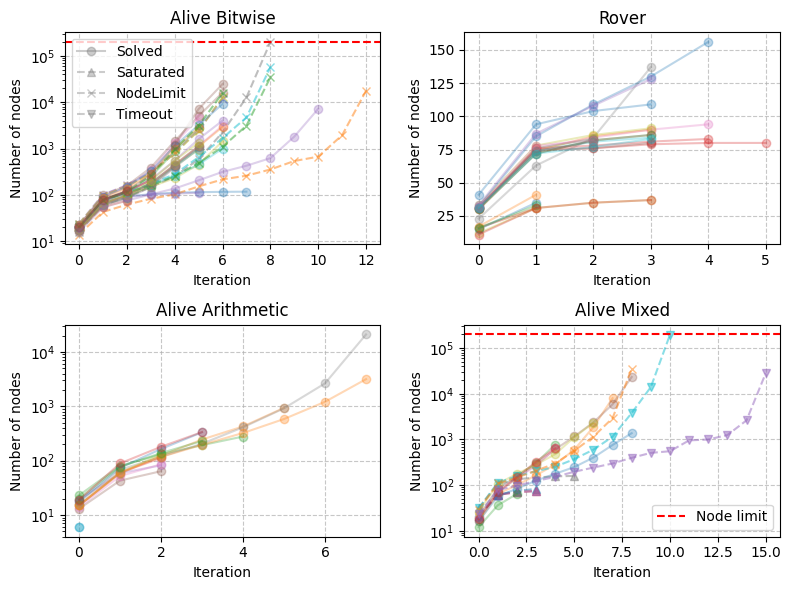

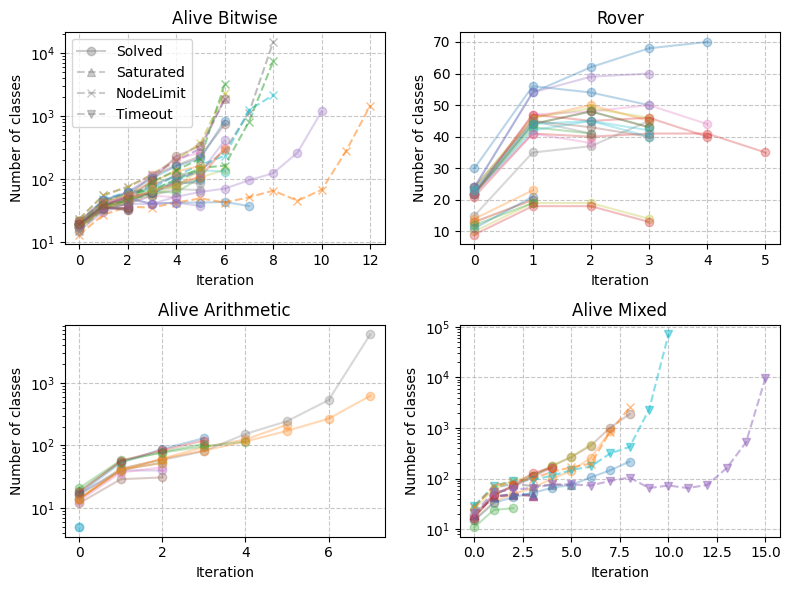

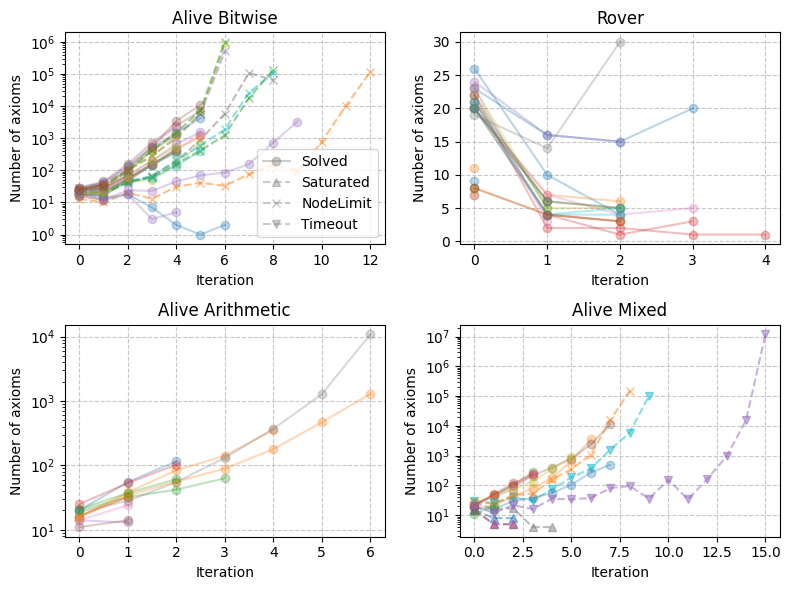

In [65]:
import numpy as np

NODE_LIMIT = 200_000

# plt.style.use('default')  # Reset to default first
# plt.rcParams.update({
#     "text.usetex": True,        # Use LaTeX to render all text
# "font.family": "serif",     # Use serif font (like LaTeX default)
# "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
# "font.size": 11,            # Match LaTeX document font size
# "axes.labelsize": 11,       # Axes label size
# "axes.titlesize": 11,       # Title size
# "legend.fontsize": 9,       # Legend font size
# "xtick.labelsize": 9,      # X tick label size
# "ytick.labelsize": 9,       # Y tick label size
# "figure.autolayout": True,  # Adjust layout automatically
# "axes.grid": True,          # Add grid (optional)
# "grid.alpha": 0.3,         # Grid transparency
# "lines.linewidth": 1.5,    # Line width
# "lines.markersize": 4,     # Marker size
# })

fail_marker = {
    'Saturated': '^',
    'NodeLimit': 'x',
    'Timeout': 'v'
}

for graph_name, fun in {
    "nodes": lambda x: x["egraph_nodes"],
    "classes": lambda x: x["egraph_classes"],
    "axioms": lambda x: sum([v for _k, v in x["applied"].items()]),
}.items():
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    for i, (bench, data) in enumerate(egraph_data.items()):
        ax = axs[i // 2][i % 2]
        any_unproven = False

        diffs = []
        maxs = []
        for theorem, info in data[0].items():
            iter_data = info["iteration_info"]

            y = []
            x = []
            x = [*range(0, len(iter_data))]
            for it in iter_data:
                # x.append((x[-1] if x != [] else 0) + it['total_time'])
                y.append(fun(it))
                # y.append(it['egraph_nodes'])
                # y.append(it['egraph_classes'])
                # y.append(sum([v for _k, v in it['applied'].items()]))
                # y.append(len(y) + 1)
            if graph_name == 'axioms':
                if y[-1] == 0:
                    y = y[:-1]
                    x = x[:-1]

            is_unproven = False
            satured = False
            if (reason := info["summary"]["stop_reason"]) != {
                "Other": "Found equivalence"
            }:
                satured = reason == "Saturated"
                # ax.text(x[-1], y[-1], theorem, horizontalalignment='center')
                is_unproven = True

            if is_unproven:
                ax.plot(x, y, f"--{fail_marker[parse_stop(info['summary']['stop_reason'])]}", alpha=0.5)
            else:
                ax.plot(x, y, "-o", alpha=0.3)

            if (non_zero := [t for t in y if t != 0]) != []:
                diffs.append(max(y) / min(non_zero))
            if y != []:
                maxs.append(max(y))
            any_unproven |= is_unproven

        if any([abs(m - NODE_LIMIT) < 50000 for m in maxs]):
            ax.axhline(NODE_LIMIT, color="red", linestyle="dashed", label="Node limit")
            ax.legend()

        ax.set_title(benchmark_names[bench])
        ax.set_xlabel("Iteration")
        ax.set_ylabel(f"Number of {graph_name}")
        # ax.set_yscale('function', functions=(lambda x: np.log(np.log(x)), lambda x: np.exp(np.exp(x))))
        if max(diffs) > 100:
            ax.set_yscale("log")

        ax.grid(True, linestyle="--", alpha=0.7)

    # Create custom legend for the first plot
    legend_elements = [
        plt.Line2D(
            [0], [0], color="grey", alpha=0.4, linestyle="-", marker="o", label="Solved"
        )] + [
        plt.Line2D(
            [0],
            [0],
            color="grey",
            alpha=0.4,
            linestyle="--",
            marker=v,
            label=k,
        ) for k,v in fail_marker.items()
            
        ]

    # Add legend to first subplot in the upper right corner
    axs[0, 0].legend(handles=legend_elements)

    plt.tight_layout()
    plt.savefig(f"{out_dir}bench_compare_{graph_name}.pdf")
    plt.show()